In [1]:
import numpy as np
import torch
import torch.nn.functional as func
from train import init
from eutils.split_utils import *
from eutils.torch.train_utils import get_data_loader, single_model, load, testEpoch
from matplotlib import pyplot as plt

In [2]:
def get_cos(dataloader, local, args, mode="test"):
    cos = []
    with torch.set_grad_enabled(mode == "train"):
        losses, predict, targets = 0, [], []

        for (wav1, wav2, eeg, label, batch_idx) in dataloader:
            if len(label.shape) == 1:
                label = func.one_hot(label, num_classes=2).float()
            local.aad_model.optim.zero_grad()

            out, all_target, weights = local.aad_model.model(wav1, wav2, eeg, label)

            loss = local.aad_model.loss(out, all_target)
            losses = losses + loss.cpu().detach().numpy()
            cos.append(out.cpu().detach().numpy())

            predict.append(out)
            targets.append(all_target)
            if mode == "train":
                loss.backward()
                local.aad_model.optim.step()

        average_loss = losses / len(dataloader)
        output = (predict, targets, average_loss) if mode == "test" else average_loss
        return cos


def cos_analysis(dataloader, local, args):
    tng_loader, tes_loader = data_loader
    cos1 = get_cos(tng_loader, local, args)
    cos2 = get_cos(tes_loader, local, args)
    cos1.extend(cos2)
    return cos1


In [3]:
# 读取模型等
# 初始化
local, args = init(name= "S1", log_path = "./result/test", local = DotMap(), args = DotMap())
process_steps = [read_extra_audio, subject_split]
process_steps += [remove_repeated, add_negative_samples]
train_steps = [load, get_data_loader]
data_loader = None
for j in range(len(train_steps)):
    local.logger.info("working process: " + train_steps[j].__name__)
    data_loader, args, local = train_steps[j](data_loader=data_loader, args=args, local=local)

2022-11-26 22:08:29,537 - INFO: data path: D:\eegdata/KUL_single_single_separate_1to32_new
2022-11-26 22:08:29,539 - INFO: window length: 128
2022-11-26 22:08:29,540 - INFO: overlap: 0.5


cma_layer: 1


2022-11-26 22:08:31,577 - INFO: cuda:0
2022-11-26 22:08:31,578 - INFO: 2618183778512
2022-11-26 22:08:31,579 - INFO: working process: load
2022-11-26 22:08:31,602 - INFO: working process: get_data_loader
2022-11-26 22:08:31,602 - INFO: overlap: 0.5
2022-11-26 22:08:31,603 - INFO: working process: read_extra_audio
E:\OneDrive - mail.scut.edu.cn\origin\EEG\eutils\util.py:169: RuntimeWarning: overflow encountered in short_scalars
  _range = np.max(data, axis=dim) - np.min(data, axis=dim)
2022-11-26 22:08:41,071 - INFO: working process: subject_split
2022-11-26 22:08:41,211 - INFO: working process: remove_repeated
2022-11-26 22:08:44,622 - INFO: remove repeated training window: []
2022-11-26 22:08:44,623 - INFO: working process: add_negative_samples
2022-11-26 22:08:44,624 - INFO: add negative samples to training window: from (4600, 6) to (9200, 7)
2022-11-26 22:08:44,624 - INFO: add negative samples to test window: from (1144, 6) to (2288, 7)


In [4]:
cos = cos_analysis(dataloader=data_loader, args=args, local=local)
cos = np.array(cos)
cos.shape

(1436, 8, 2)

In [5]:
cos[0]

array([[ 0.1043131 , -0.05273702],
       [ 0.32050562,  0.2969748 ],
       [-0.04107966,  0.00298737],
       [ 0.01327665,  0.05716961],
       [ 0.00770014,  0.00589059],
       [ 0.02801686,  0.03135058],
       [ 0.0053338 ,  0.00534561],
       [ 0.09923122,  0.1119356 ]], dtype=float32)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

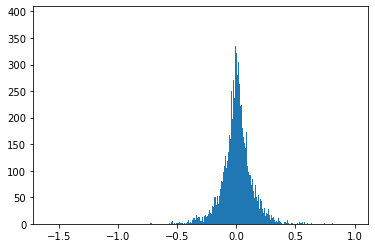

In [6]:
plt.hist(cos.flatten(), bins=1000)